In [1]:
import re
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import string
import nltk
import warnings 
warnings.filterwarnings("ignore", category=DeprecationWarning)

%matplotlib inline

df = pd.read_csv('training_cleaned.csv')

df["Sentiment"] = df["Sentiment"].map({4:1,0:0})

# Data Exploration

#### Confirm only string objects are in the data, by only selecting str types from intial dataset and create a copy of the dataframe

In [2]:
df_new = df.loc[df['Tweet'].apply(type) == str].copy()

print("Old Dataset with all types", df.count())
print("New Dataset with only str types",df_new.count())

Old Dataset with all types Tweet        31784
Sentiment    31938
dtype: int64
New Dataset with only str types Tweet        31784
Sentiment    31784
dtype: int64


#### Does length of tweet affect sentiment?

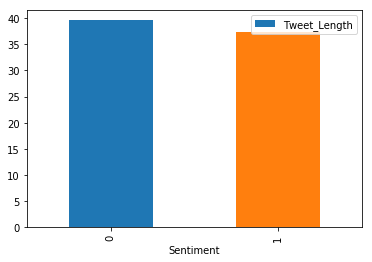

In [3]:
df_new['Tweet_Length'] = df_new['Tweet'].apply(lambda x: len(x))
sentence_length = df_new.groupby(['Sentiment']).mean()
sentence_length.plot(y='Tweet_Length',kind='bar')

# Word Clouds

We want to get an understanding of what are the most common words in all the tweets

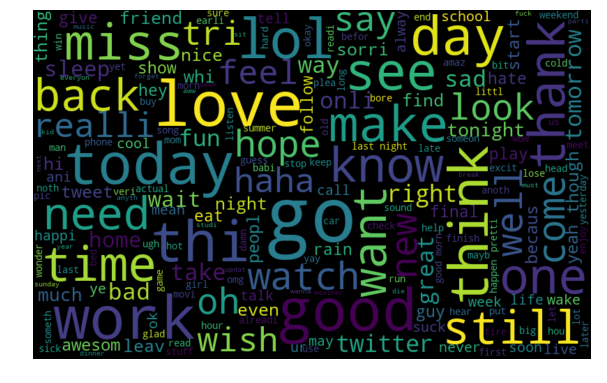

In [4]:
all_words = ' '.join([text for text in df_new['Tweet']])
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

There are a lot of words associated with positive sentiment which occur the most (ie. Love, Go, Today, LoL, Think, Good, Work, Still, Time, Thank, See, Day, Make, Know..). 

However, it is hard to see any negative words, so the positive labeled tweets and negative labeled tweets are performed with “Word Cloud” separately.

## Negative Sentiment Words

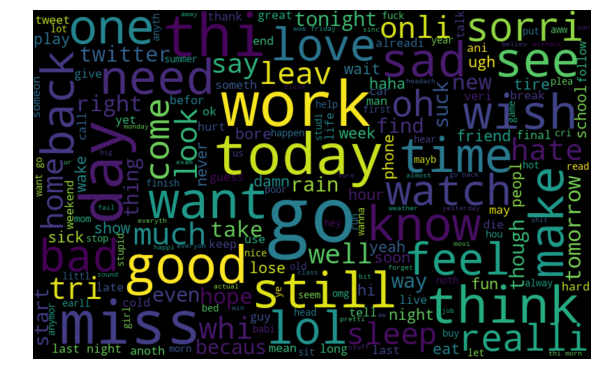

In [5]:
normal_words =' '.join([text for text in df_new['Tweet'][df_new['Sentiment'] == 0]])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

The most common occurring words are: Work, Go, Today, Still, Think, Miss, Sad, Good, Day, Bad…

There are some overlap between the positive and negative words. 

It’s interesting to see  there are very positive words in this "Negative" cloud, and they are also in big fonts, such as Good, LoL, Love. 

## Postive Sentiment Words

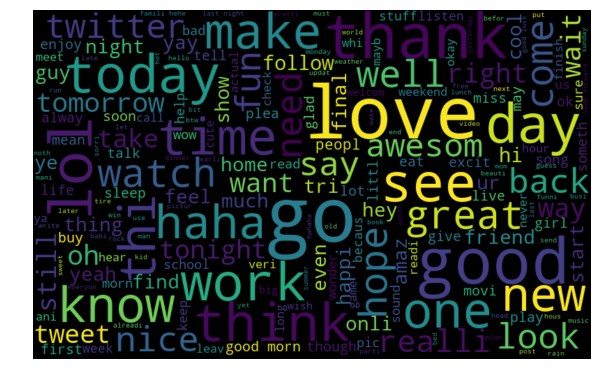

In [6]:
normal_words =' '.join([text for text in df_new['Tweet'][df_new['Sentiment'] == 1]])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

The Word Cloud for the positive tweets is very similar to the Word Cloud for all tweets. 

The most common words are: Love, Go, Good, LoL, Thank, Today, Day, Know, See, Think, New,Haha…

Compare to the Common Occurring Words in Negative Sentiment Word Cloud, there are some overlap here, such as Love, Good, Go, LoL, Day, Think. 

# Preparion for Data Visualization

To get term frequency data. What kind of words are used in the tweets, and how many times it is used in entire corpus.

Reference: https://towardsdatascience.com/another-twitter-sentiment-analysis-with-python-part-2-333514854913

In [7]:
from sklearn.feature_extraction.text import CountVectorizer
cvec = CountVectorizer()
cvec.fit(df_new.Tweet)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [8]:
len(cvec.get_feature_names()) #It looks like count vectorizer has extracted 21117 words out of the corpus.

21117

In [9]:
neg_doc_matrix = cvec.transform(df_new[df_new.Sentiment == 0].Tweet)
pos_doc_matrix = cvec.transform(df_new[df_new.Sentiment == 1].Tweet)
neg_tf = np.sum(neg_doc_matrix,axis=0)
pos_tf = np.sum(pos_doc_matrix,axis=0)
neg = np.squeeze(np.asarray(neg_tf))
pos = np.squeeze(np.asarray(pos_tf))
term_freq_df = pd.DataFrame([neg,pos],columns=cvec.get_feature_names()).transpose()

In [10]:
term_freq_df.head()

,0,1
aa,5,3
aaa,2,1
aaaa,0,1
aaaaa,1,0
aaaaaa,0,1


In [11]:
term_freq_df.columns = ['negative', 'positive']
term_freq_df['total'] = term_freq_df['negative'] + term_freq_df['positive']
term_freq_df.sort_values(by='total', ascending=False).iloc[:10]

,negative,positive,total
not,4779,2131,6910
go,2281,1615,3896
get,2033,1600,3633
good,869,1556,2425
day,1036,1067,2103
thi,1047,786,1833
work,1152,614,1766
like,877,802,1679
love,428,1244,1672
no,1072,425,1497


In [12]:
len(term_freq_df)

21117

In [13]:
# term_freq_df.to_csv('term_freq_df.csv',encoding='utf-8')

# Zipf's Distribution

Let's see how the tweet tokens and their frequencies look like on a plot.

Reference: https://towardsdatascience.com/another-twitter-sentiment-analysis-with-python-part-3-zipfs-law-data-visualisation-fc9eadda71e7

Text(0.5, 1.0, 'Top 100 words in tweets')

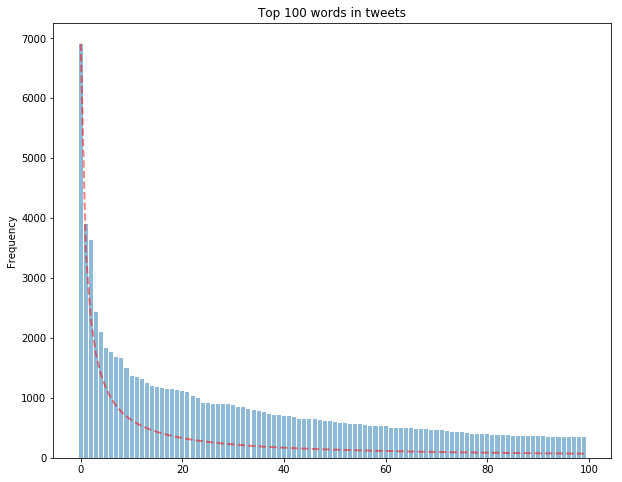

In [14]:
y_pos = np.arange(100)
plt.figure(figsize=(10,8))
s = 1
expected_zipf = [term_freq_df.sort_values(by='total', ascending=False)['total'][0]/(i+1)**s for i in y_pos]
plt.bar(y_pos, term_freq_df.sort_values(by='total', ascending=False)['total'][:100], align='center', alpha=0.5)
plt.plot(y_pos, expected_zipf, color='r', linestyle='--',linewidth=2,alpha=0.5)
plt.ylabel('Frequency')
plt.title('Top 100 words in tweets')

On the X-axis is the rank of the frequency from highest rank from left up to 100th rank to the right. Y-axis is the frequency observed in the dataset. 

Based on Zipf's Law, given a large sample of words used, the frequency of any word is inversely proportional to its rank in the frequency table. However, the actual observations in this case does not strictly follow Zipf's distribution. It has more area above the expected Zipf curve in higher ranked words. The reason might be a tweet has maximum character limit, so it uses frequent words more heavily than other text corpora.

## Top 25 words in all tweets

Text(0.5, 1.0, 'Top 25 words in all tweets')

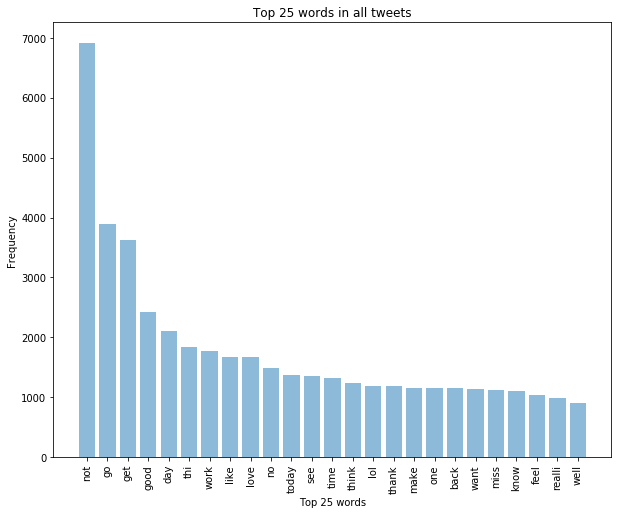

In [15]:
y_pos = np.arange(25)
plt.figure(figsize=(10,8))
plt.bar(y_pos, term_freq_df.sort_values(by='total', ascending=False)['total'][:25], align='center', alpha=0.5)
plt.xticks(y_pos, term_freq_df.sort_values(by='total', ascending=False)['total'][:25].index,rotation='vertical')
plt.ylabel('Frequency')
plt.xlabel('Top 25 words')
plt.title('Top 25 words in all tweets')

## Top 25 words in negative tweets

Text(0.5, 1.0, 'Top 25 words in negative tweets')

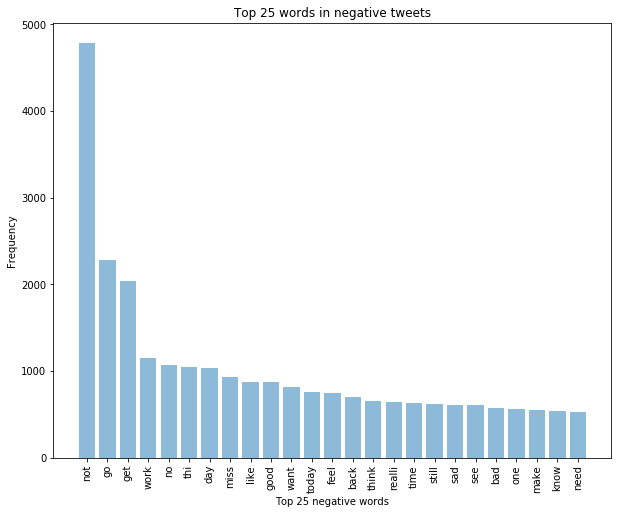

In [16]:
y_pos = np.arange(25)
plt.figure(figsize=(10,8))
plt.bar(y_pos, term_freq_df.sort_values(by='negative', ascending=False)['negative'][:25], align='center', alpha=0.5)
plt.xticks(y_pos, term_freq_df.sort_values(by='negative', ascending=False)['negative'][:25].index,rotation='vertical')
plt.ylabel('Frequency')
plt.xlabel('Top 25 negative words')
plt.title('Top 25 words in negative tweets')

## Top 25 words in positive tweets

Text(0.5, 1.0, 'Top 25 words in positive tweets')

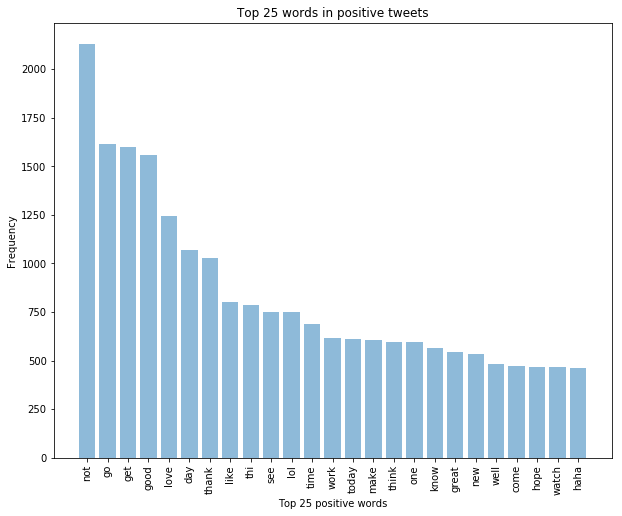

In [17]:
y_pos = np.arange(25)
plt.figure(figsize=(10,8))
plt.bar(y_pos, term_freq_df.sort_values(by='positive', ascending=False)['positive'][:25], align='center', alpha=0.5)
plt.xticks(y_pos, term_freq_df.sort_values(by='positive', ascending=False)['positive'][:25].index,rotation='vertical')
plt.ylabel('Frequency')
plt.xlabel('Top 25 positive words')
plt.title('Top 25 words in positive tweets')